#
# Multiple Absorbers on a Multifloor Building
#



In [37]:
%matplotlib inline

In [38]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

#
# Solving High NDOF Systems
#

The generate_matrices function finds the stiffness and damping matrices for solving the system.

This function is geometry specific, where we are considering a system with an arbitrary number of dampers on an arbitrary number of floors.


In [39]:
def generate_matrices(nf, mf, lf, kf, mdt, ld, w, f):
    """
    Creates matrices for linear matrix equation to solve for the frequency response
    :param nf: Number of floors
    :param mf: Mass of floors
    :param lf: Lambda of floors
    :param kf: Spring const. of floors
    :param mdt: Total mass of dampers
    :param ld: Lambda of dampers
    :param w: Frequencies of dampers
    :return: M (Mass matrix), L (Lambda matrix), K (Stiffness matrix), F (Force matrix)
    """

    nd = len(w.nonzero()[0]) # Total number of dampers
    ndf = [len(floor.nonzero()[0]) for floor in w] # Number of dampers on each floor
    n = nf + nd  # Number of degrees of freedom of the system
    M, L, K = np.zeros((n, n)), np.zeros((n, n)), np.zeros((n, n))  # Set up empty matrices
    F = np.zeros(n)

    # Implement stiffness matrix equation

    mi = mdt / nd if nd > 0 else 0
    for i in range(nf - 1):
        M[i][i] = mf  # Set masses along leading diagonal
        K[i][i], K[i + 1][i], K[i][i + 1] = 2*kf + sum((w[i]**2)*mi), -kf, -kf # Set stiffness
        L[i][i], L[i + 1][i], L[i][i + 1] = 2 * lf + ndf[i]*ld, -lf, -lf
    K[nf - 1][nf - 1] = kf + sum((w[nf - 1]**2)*mi)
    L[nf - 1][nf - 1] = lf + ndf[nf - 1]*ld
    M[nf - 1][nf - 1] = mf

    c = nf
    for i, floor in enumerate(w):
        a = floor.nonzero()
        for fr, d in enumerate(floor[a]):
            p = c + fr
            M[p][p] = mi
            K[p][i], K[i][p], K[p][p] = -(d**2*mi), -(d**2*mi), (d**2*mi)
            L[p][i], L[i][p], L[p][p] = -ld, -ld, ld
        c += len(a[0])
    F[0] = f

    return M, L, K, F

In [40]:
def freq_response(w_list, M, L, K, F):

    """Return complex frequency response of system"""

    return np.array(
        [np.linalg.solve(-w*w * M + 1j * w * L + K, F) for w in w_list]
    )

In [41]:
def time_response(t_list, M, L, K, F):

    """Return time response of system"""

    mm = M.diagonal()

    def slope(t, y):
        xv = y.reshape((2, -1))
        a = (F - L@xv[1] - K@xv[0]) / mm
        s = np.concatenate((xv[1], a))
        return s

    solution = scipy.integrate.solve_ivp(
        fun=slope,
        t_span=(t_list[0], t_list[-1]),
        y0=np.zeros(len(mm) * 2),
        method='Radau',
        t_eval=t_list
    )

    return solution.y[0:len(mm), :].T

In [42]:
def plot(f, t, nf, hz, sec):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 10))
    

    for i in range(nf):
        ax1.plot(hz, f[:, i], label=("Floor " + str(i + 1)))
        ax1.set_xlim(0, 10)
        ax1.set_ylim(-0.005, 0.005)
        ax1.set_xlabel('Frequency / hz')
        ax1.set_ylabel('Response')
        ax1.grid(True)

        ax2.plot(sec, t[:, i], label=("Floor " + str(i)))
        ax2.set_xlim(0, 10)
        ax2.set_ylim(-0.0003 / 2, 0.0003)
        ax2.set_xlabel('Time / s')
        ax2.set_ylabel('Response')
        ax2.grid(True)


    fig.tight_layout()
    plt.legend()
    plt.show()

#
# Testing expected behaviour
#
At high damping, behaviour --> undamped.

At low damping, "modulation effect" energy transfers between damper and building.


## No Damping

In [43]:
nf, mf, lf, kf = 1, 3.94, 1.98, 2100
mdt, ld, w = nf * 0.15, 100, 2 * np.pi * np.array([[3.675]])
f = 0.25

hz = np.linspace(0, 10, 10001)
sec = np.linspace(0, 30, 10001)

In [44]:
M0, L0, K0, F0 = generate_matrices(nf, mf, lf, kf, mdt, 0, np.array([[0] for i in range(nf)]), f)
fr_undamped = np.real(freq_response(hz * 2 * np.pi, M0, L0, K0, F0))
tr_undamped = np.real(time_response(sec, M0, L0, K0, F0))

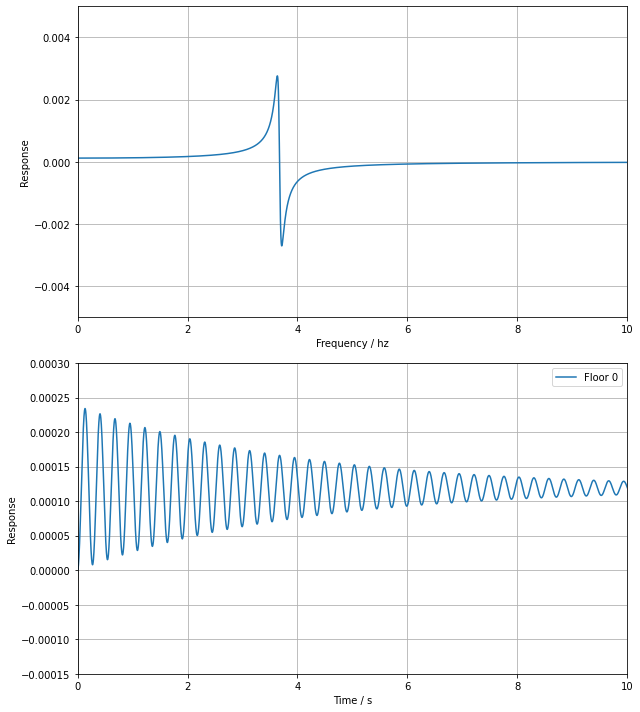

In [45]:
plot(fr_undamped, tr_undamped, nf, hz, sec)

## High Damping

In [46]:
M, L, K, F = generate_matrices(nf, mf, lf, kf, mdt, ld, w, f)
f_response = np.real(freq_response(hz * 2 * np.pi, M, L, K, F))
t_response = np.real(time_response(hz * 2 * np.pi, M, L, K, F))

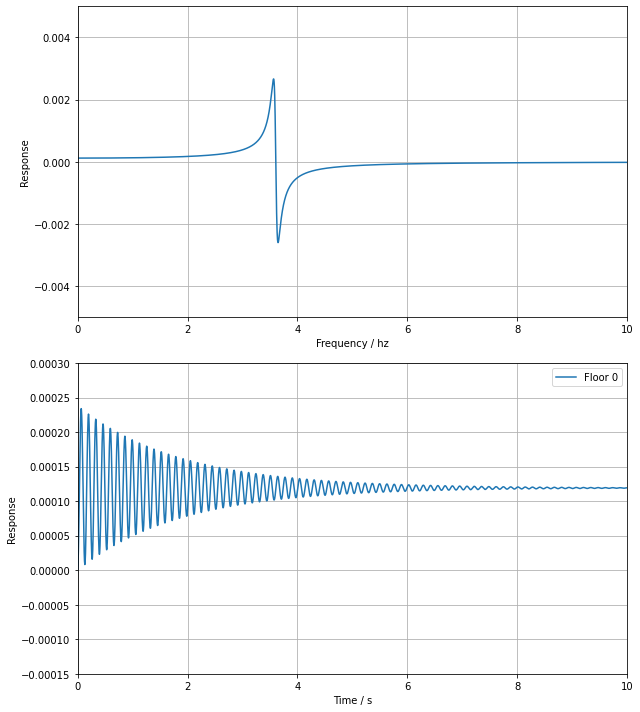

In [47]:
plot(f_response, t_response, nf, hz, sec)

## Low Damping

In [48]:
ld = 0.01

M, L, K, F = generate_matrices(nf, mf, lf, kf, mdt, ld, w, f)
f_response = np.real(freq_response(hz * 2 * np.pi, M, L, K, F))
t_response = time_response(hz * 2 * np.pi, M, L, K, F)

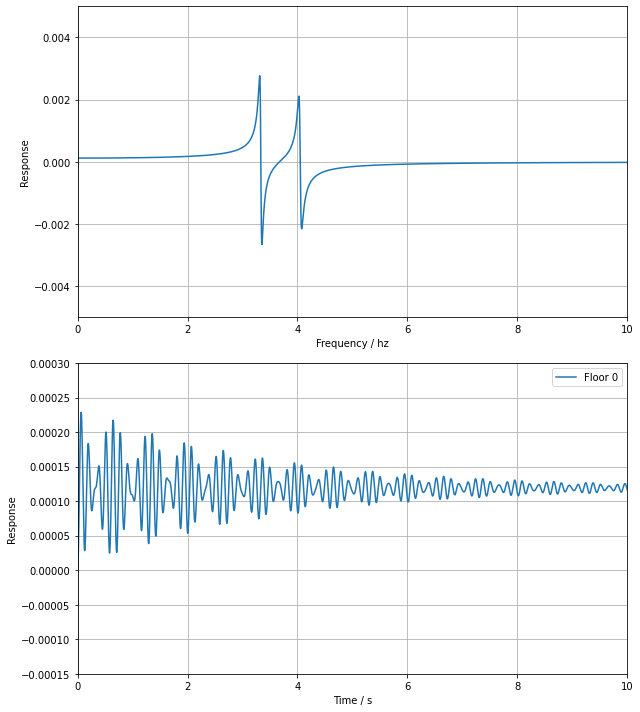

In [49]:
plot(f_response, t_response, nf, hz, sec)

#
# Effect of splitting up dampers
#

With total damping mass conserved, this plot demonstrates the 
effect of dividing into smaller dampers with the same natural frequency.

The clear effect of dividing up the masses is to reduce the effectiveness of the damping.

In this case we are taking the effectiveness to be the ratio of the undamped to damped peak response, but the metric used for this would depend on the design priorities.

In [50]:
def response_peak(w, M, L, K, F):
    # Change name, finds response at given freq
    return np.abs(np.array(np.linalg.solve(-w * w * M + 1j * w * L + K, F)))

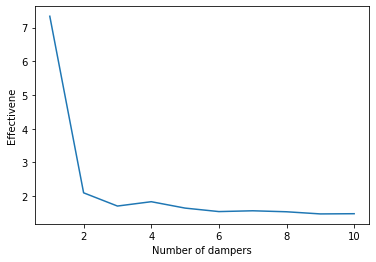

In [51]:
nm = 10

E = np.zeros(nm)

m = [3.94]
l = [1.98]
k = [2100]
f = [0.25]

# Peak response of undamped set up
f0_max = response_peak(3.675 *2 * np.pi, np.array([m]), np.array([l]), np.array([k]), np.array(f))

ns = np.linspace(1, nm, nm)

# Iterate over number of masses, same total mass
for i in range(len(ns)):

    M, L, K, F = generate_matrices(1, 3.94, 1.98, 2100, 0.15, 1, 2 *
                        np.pi * np.array([[3.7] for _ in range(i + 1)]), 0.25)

    # Peak response of this damper set up
    f_max = np.abs(response_peak(3.675 * 2 * np.pi, M, L, K, F)[0])

    E[i] = f0_max / f_max

plt.xlabel("Number of dampers")
plt.ylabel("Effectivene")
plt.plot(ns, E)
plt.show()

#
# Damped Response
#

Compares damped and undamped response of a NDOF system, dampers on each floor

In [52]:
# Set system properties and time / freq analysis domains
# (nf, mf, lf, kf, mdt, ld, w, f)
# [[3.05, 6.2], [1, 3.05], [1, 0], [1, 6.2], [1, 3.05]]
# [[3.7] for i in range(nf)]

nf, mf, lf, kf = 3, 3.94, 1.98, 2100
mdt, ld, w = nf * 0.15, 0.3, 2 * np.pi * np.array([[4.6, 0], [0, 0], [1.6, 4.6]])
f = 0.25

hz = np.linspace(0, 10, 10001)
sec = np.linspace(0, 30, 10001)

In [53]:
M0, L0, K0, F0 = generate_matrices(nf, mf, lf, kf, mdt, 0, np.array([[0] for i in range(nf)]), f)
fr_undamped = np.real(freq_response(hz * 2 * np.pi, M0, L0, K0, F0))
tr_undamped = np.real(time_response(sec, M0, L0, K0, F0))

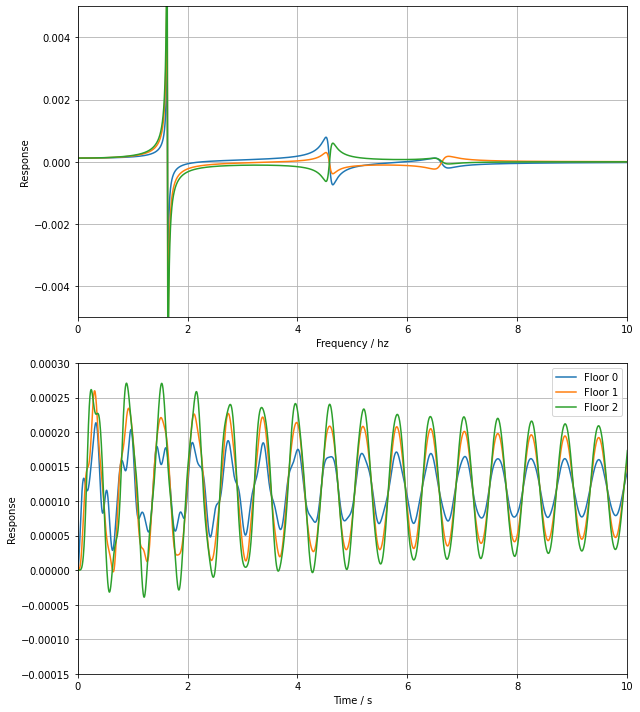

In [54]:
plot(fr_undamped, tr_undamped, nf, hz, sec)

In [55]:
M, L, K, F = generate_matrices(nf, mf, lf, kf, mdt, ld, w, f)
f_response = np.real(freq_response(hz * 2 * np.pi, M, L, K, F))
t_response = np.real(time_response(hz * 2 * np.pi, M, L, K, F))

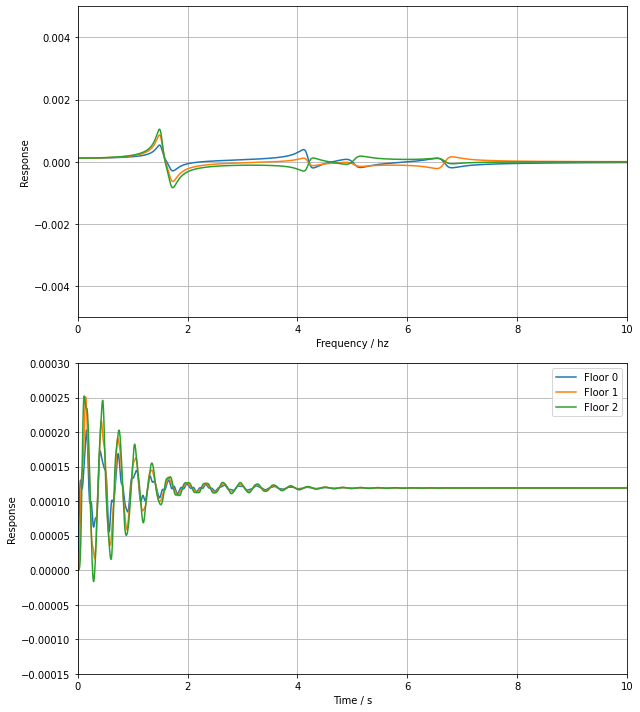

In [56]:
plot(f_response, t_response, nf, hz, sec)

In [57]:
# Different damper configuration and optimised damping
ld, w = 1.7, 2 * np.pi * np.array([[0, 0], [0, 0], [0, 1.6]])

M, L, K, F = generate_matrices(nf, mf, lf, kf, mdt, ld, w, f)
f_response = np.real(freq_response(hz * 2 * np.pi, M, L, K, F))
t_response = np.real(time_response(hz * 2 * np.pi, M, L, K, F))

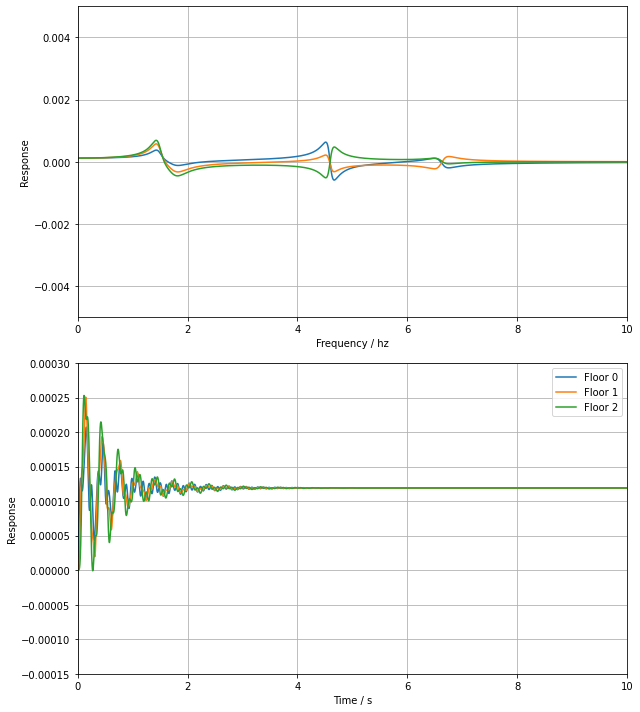

In [58]:
plot(f_response, t_response, nf, hz, sec)


# 
# Lambda Sweep
#

Sweeping damping factor from 0.02 to 2 Hz, animated in FuncAnimation

In [59]:
f_response, t_response = np.zeros_like(hz), np.zeros_like(hz)

ls = np.linspace(1, 100, 100)
data = np.zeros((len(ls), len(hz)))
data1 = np.zeros((len(ls), len(hz)))
data2 = np.zeros((len(ls), len(hz)))

for i, ld in enumerate(ls):

    M, L, K, F = generate_matrices(nf, mf, lf, kf, mdt, ld / 50, w, f)
    f_response = freq_response(hz * 2 * np.pi, M, L, K, F)
    data[i] = np.real(f_response[:, 0])
    data1[i] = np.real(f_response[:, 1])
    data2[i] = np.real(f_response[:, 2])


In [60]:
%%capture

plt.rcParams['figure.figsize'] = (5,3)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

fig, ax = plt.subplots(figsize = (9, 5))
A, = plt.plot([], [], 'r-')
B, = plt.plot([], [], 'b-')
C, = plt.plot([], [], 'g-')

def update(frame):

    ax.set_title("Lambda = " + str(frame/50))
    A.set_data(hz, data[int(frame) - 1])
    B.set_data(hz, data1[int(frame)-1])
    C.set_data(hz, data2[int(frame)-1])

    return A, B, C,


def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.005, 0.005)
    return A, B, C


ani = animation.FuncAnimation(fig, update, frames=ls, interval=100, init_func=init, repeat=True)

In [61]:
ani

# Conclusions

This leaves an optimisation problem, natural frequencies, mass distribution and damping factors can be adjusted for a given building to give an ideal response for the design requirements.

Another way this damping set up can be varied is by considering the effect of attaching the dampers between floors, not necessarily adjacent ones, as seen in the Taipei 101 skyscraper.